## 1. Data Acquisition and Preparation

In [1]:
import math
import functools
import numpy as np
import pandas as pd
import yfinance as yf
import xgboost as xgb
import matplotlib.pyplot as plt
import scipy.optimize as sco
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

### 1.1 Define Asset Universe
Create a diverse universe.

In [3]:
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "JPM", "BAC", "JNJ", "WMT", "XOM",  # U.S. Equities
    "EFA", "EEM",  # International Equities
    "TLT",        # Fixed Income
    "GLD"         # Commodities
]
data = yf.download(tickers, start = "2018-01-01", end = "2025-02-15", auto_adjust = False)

# Display the downloaded data.
data

[*********************100%***********************]  13 of 13 completed


Price        Adj Close                                               \
Ticker            AAPL        AMZN        BAC        EEM        EFA   
Date                                                                  
2018-01-02   40.426819   59.450500  25.044065  40.555492  56.610878   
2018-01-03   40.419788   60.209999  24.960302  40.944069  56.882629   
2018-01-04   40.607533   60.479500  25.286961  41.146805  57.506039   
2018-01-05   41.069862   61.457001  25.404230  41.501591  57.825729   
2018-01-08   40.917328   62.343498  25.228334  41.501591  57.809757   
...                ...         ...        ...        ...        ...   
2025-02-10  227.351852  233.139999  46.105621  43.300526  78.785576   
2025-02-11  232.315353  232.759995  46.224174  43.132156  79.159103   
2025-02-12  236.559784  228.929993  45.651188  43.369854  79.453995   
2025-02-13  241.213684  230.369995  45.769737  43.647167  80.417313   
2025-02-14  244.279663  228.679993  46.392120  43.983906  80.535271   

Price                                                                   ...  \
Ticker             GLD       GOOGL         JNJ         JPM        MSFT  ...   
Date                                                                    ...   
2018-01-02  125.150002   53.340595  112.882553   87.571877   79.328522  ...   
2018-01-03  124.820000   54.250641  113.960892   87.661133   79.697708  ...   
2018-01-04  125.459999   54.461376  113.952759   88.916901   80.399178  ...   
2018-01-05  125.330002   55.183544  114.893257   88.346107   81.395981  ...   
2018-01-08  125.309998   55.378376  115.039185   88.476562   81.479019  ...   
...                ...         ...         ...         ...         ...  ...   
2025-02-10  268.369995  186.030289  151.714554  269.380737  410.641235  ...   
2025-02-11  267.390015  184.883011  153.573593  273.306549  409.864227  ...   
2025-02-12  267.670013  183.177032  152.717834  273.763763  407.473419  ...   
2025-02-13  270.309998  185.701065  154.675247  274.628418  408.967682  ...   
2025-02-14  266.290009  184.793198  153.593262  274.896759  406.865723  ...   

Price         Volume                                                    \
Ticker           EEM       EFA       GLD     GOOGL       JNJ       JPM   
Date                                                                     
2018-01-02  68969400  26530000  11762500  31766000   6842100  13578800   
2018-01-03  56228700  33384900   7904300  31318000   5350500  11901000   
2018-01-04  52154900  23974400   7329700  26052000   4837600  12953700   
2018-01-05  50026900  17483800   5739900  30250000   6158800  14155000   
2018-01-08  36998200  21733700   3566700  24644000   5129800  12466500   
...              ...       ...       ...       ...       ...       ...   
2025-02-10  19596700   7287300  13250300  23105600   6936200   8627400   
2025-02-11  19596800   7583700   7169500  21239500   7554500   7196400   
2025-02-12  19986000  17271400   9328600  22072600   7746000   6683900   
2025-02-13  22841000  17212300   8347500  21402500  10704700   8398700   
2025-02-14  24329400   8051800  11546700  20448400   6411800   5688600   

Price                                               
Ticker          MSFT       TLT       WMT       XOM  
Date                                                
2018-01-02  22483800  16238200  30451500  11469300  
2018-01-03  26061400   8605100  26710800  13957700  
2018-01-04  21912000   9217900  20491200  10863000  
2018-01-05  23407100  10915400  21852000  11047600  
2018-01-08  22113000   8850600  26531700  10927100  
...              ...       ...       ...       ...  
2025-02-10  20817900  22736100  15274600  12142200  
2025-02-11  18140600  21513000  11953600  12713100  
2025-02-12  19121700  48536200  15162100  18244100  
2025-02-13  23891700  42718100  12604400  15460000  
2025-02-14  22758500  27460700  14109500  15733500  

[1791 rows x 78 columns]

## 2. Feature Engineering

Compute factros :

- Momentum :
    Calculate momentum as the percentage change over a specified window.
- Volatility :
    Compute rolling volatility using the standard deviation of daily returns (which approximate log daily returns).
- Average Volume :
    Determine the rolling average volume over the lookback period.


As I am going to build a dynamic portfolio, I define also lookback period and rebalance period.

In [7]:
lookback = 126
rebalance_period = 21

adj_close = data["Adj Close"].dropna()
daily_returns = adj_close.pct_change().dropna()

momentum = (adj_close / adj_close.shift(21) -1).dropna()
volatility = (np.log(1 + daily_returns)).rolling(lookback).std().dropna()
avgvolume = data["Volume"].rolling(lookback).mean().dropna()

factors_df = pd.DataFrame({})

for ticker in tickers :
    factors_df[f"Momentum_{ticker}"] = momentum[ticker]
    factors_df[f"Volatility_{ticker}"] = volatility[ticker]
    factors_df[f"AvgVolume_{ticker}"] = avgvolume[ticker]
    
factors_df.dropna(how = "any")

,Momentum_AAPL,Volatility_AAPL,AvgVolume_AAPL,Momentum_MSFT,Volatility_MSFT,AvgVolume_MSFT,Momentum_AMZN,Volatility_AMZN,AvgVolume_AMZN,Momentum_GOOGL,...,AvgVolume_EFA,Momentum_EEM,Volatility_EEM,AvgVolume_EEM,Momentum_TLT,Volatility_TLT,AvgVolume_TLT,Momentum_GLD,Volatility_GLD,AvgVolume_GLD
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,-0.041234,0.015174,1.308631e+08,-0.025770,0.016675,3.049652e+07,0.017228,0.017895,1.039207e+08,-0.031881,...,2.655972e+07,-0.076700,0.013022,7.215175e+07,0.023832,0.006128,8.977711e+06,-0.030400,0.006081,7.402794e+06
2018-07-05,-0.040919,0.015188,1.304531e+08,-0.023779,0.016681,3.044030e+07,0.001993,0.017873,1.039007e+08,-0.008453,...,2.644233e+07,-0.071926,0.012989,7.224037e+07,0.024368,0.006119,8.940055e+06,-0.030932,0.006087,7.379362e+06
2018-07-06,-0.030983,0.015229,1.302960e+08,-0.012977,0.016706,3.041905e+07,0.008775,0.017875,1.038417e+08,0.007088,...,2.638413e+07,-0.073110,0.013044,7.238147e+07,0.036112,0.006126,8.904039e+06,-0.033030,0.006068,7.344578e+06
2018-07-09,-0.014887,0.015244,1.301721e+08,0.009616,0.016684,3.037782e+07,0.029432,0.017878,1.037571e+08,0.028966,...,2.640951e+07,-0.041820,0.013123,7.262374e+07,0.019569,0.006147,8.864652e+06,-0.030197,0.006073,7.331363e+06
2018-07-10,-0.007042,0.015240,1.300251e+08,0.004821,0.016685,3.035544e+07,0.035083,0.017848,1.035545e+08,0.030396,...,2.638767e+07,-0.042132,0.013123,7.283652e+07,0.022557,0.006147,8.840121e+06,-0.033168,0.006075,7.332856e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-10,-0.060979,0.013499,4.879313e+07,-0.029065,0.014038,2.040215e+07,0.049566,0.017584,3.667432e+07,-0.038567,...,1.096591e+07,0.045933,0.010517,2.659166e+07,0.038214,0.008184,3.763072e+07,0.091556,0.009314,6.709295e+06
2025-02-11,-0.016780,0.013579,4.888453e+07,-0.017926,0.014021,2.039313e+07,0.063122,0.017585,3.657363e+07,-0.034993,...,1.093862e+07,0.059869,0.010514,2.657939e+07,0.038445,0.008150,3.754636e+07,0.077273,0.009324,6.730950e+06
2025-02-12,0.011649,0.013657,4.894180e+07,-0.019535,0.014030,2.041185e+07,0.047926,0.017665,3.659119e+07,-0.038741,...,1.101229e+07,0.073021,0.010521,2.661862e+07,0.024713,0.008225,3.773902e+07,0.089241,0.009218,6.760849e+06


## 3. Exploratory Data Analysis

### 3.1 Correlation Matrix

Visualize the correlation between computed factors and daily returns.

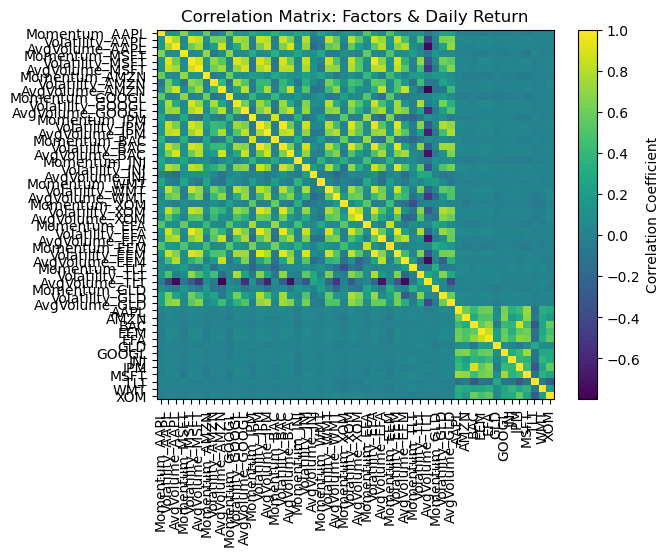

Factor Correlation Matrix:
                   Momentum_AAPL  Volatility_AAPL  AvgVolume_AAPL  \
Momentum_AAPL          1.000000         0.147406        0.143011   
Volatility_AAPL        0.147406         1.000000        0.772318   
AvgVolume_AAPL         0.143011         0.772318        1.000000   
Momentum_MSFT          0.669024         0.058043        0.090795   
Volatility_MSFT        0.135618         0.912065        0.598090   
AvgVolume_MSFT         0.124215         0.835484        0.756803   
Momentum_AMZN          0.573412         0.080823        0.041131   
Volatility_AMZN       -0.075194         0.616576        0.217680   
AvgVolume_AMZN         0.060653         0.634545        0.878406   
Momentum_GOOGL         0.549097         0.006669        0.015465   
Volatility_GOOGL       0.138411         0.777460        0.306811   
AvgVolume_GOOGL        0.111842         0.709950        0.746182   
Momentum_JPM           0.302788        -0.029458       -0.057938   
Volatility_JPM      

In [10]:

shifted_factors = factors_df.shift(1)
factors_return_corr = pd.concat([shifted_factors, daily_returns], axis = 1).corr()

plt.figure()
plt.imshow(factors_return_corr, aspect = "auto")
plt.colorbar(label = "Correlation Coefficient")
plt.xticks(range(len(factors_return_corr.columns)), factors_return_corr.columns, rotation = 90)
plt.yticks(range(len(factors_return_corr.columns)), factors_return_corr.columns)
plt.title("Correlation Matrix: Factors & Daily Return")
plt.show()

print("Factor Correlation Matrix:\n", factors_return_corr)


### 3.2 Histograms

Plot histograms to explore the distribution of daily returns for each asset.

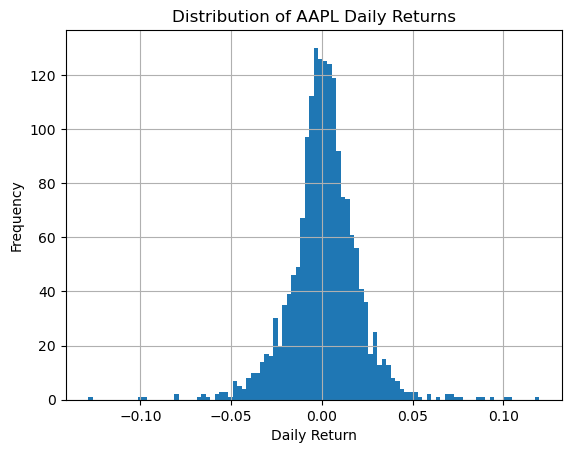

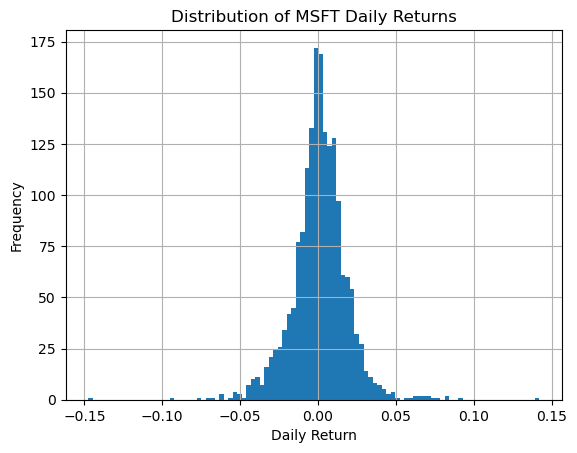

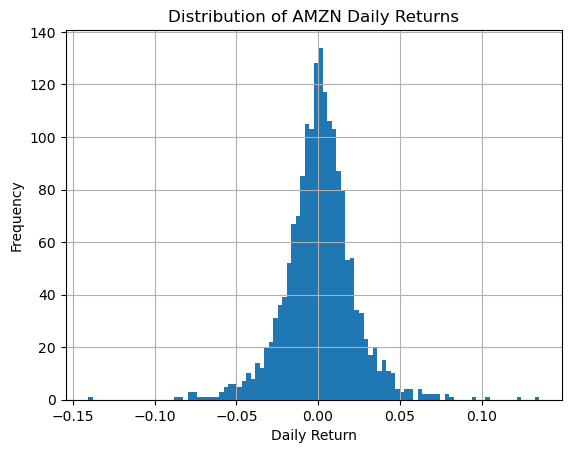

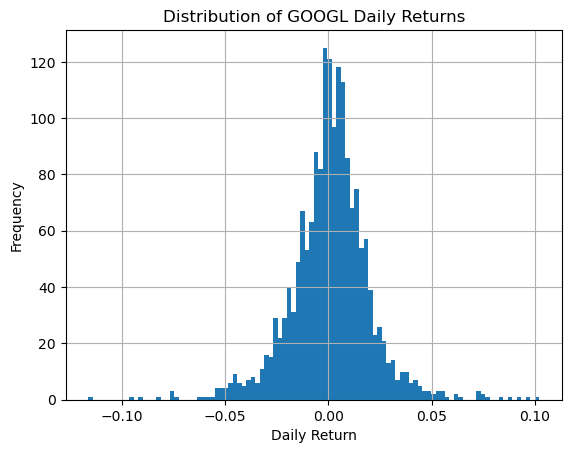

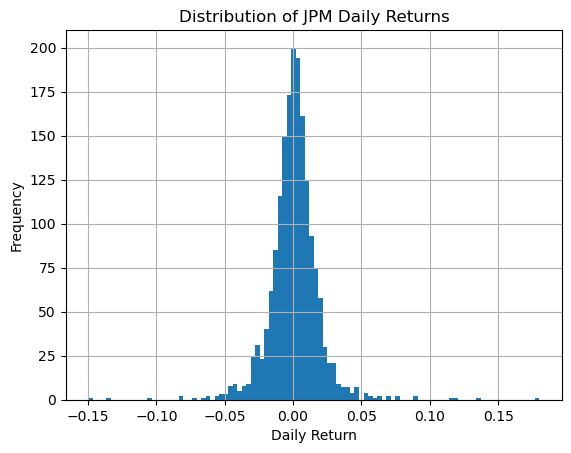

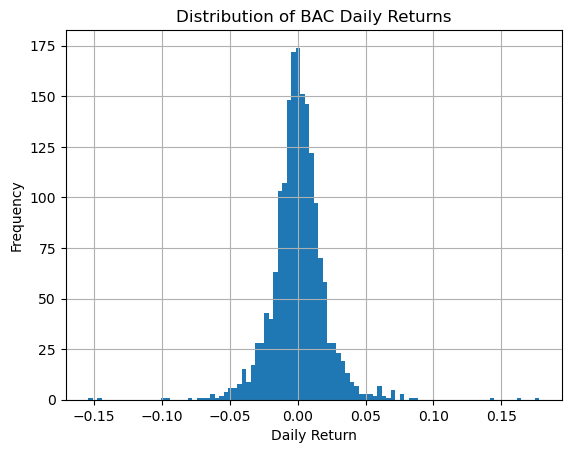

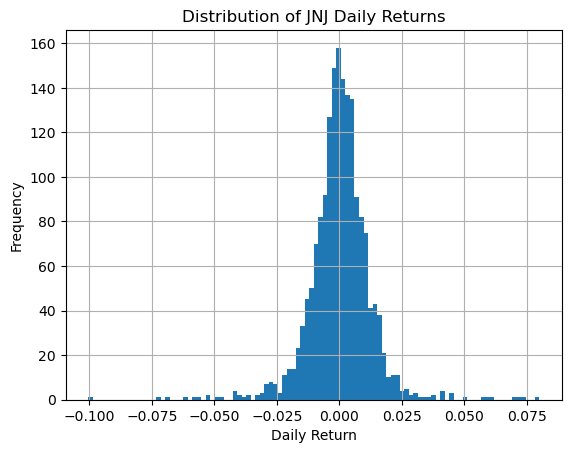

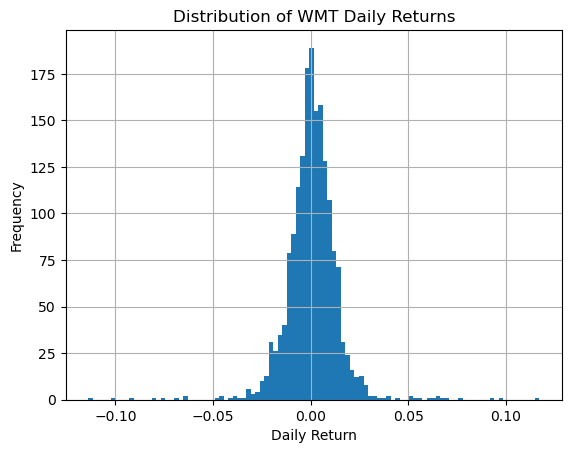

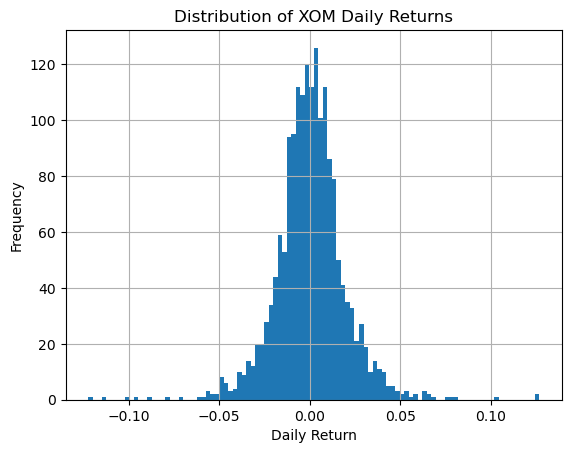

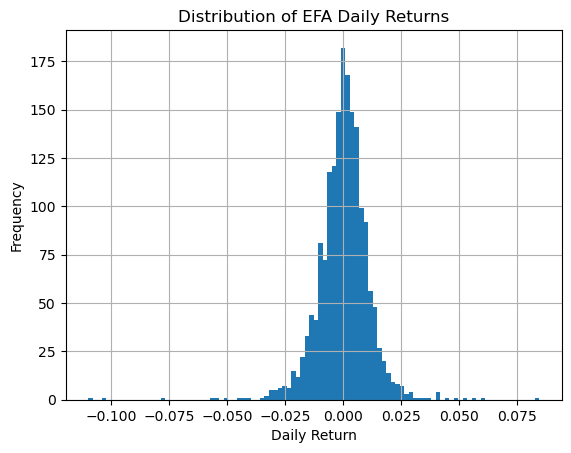

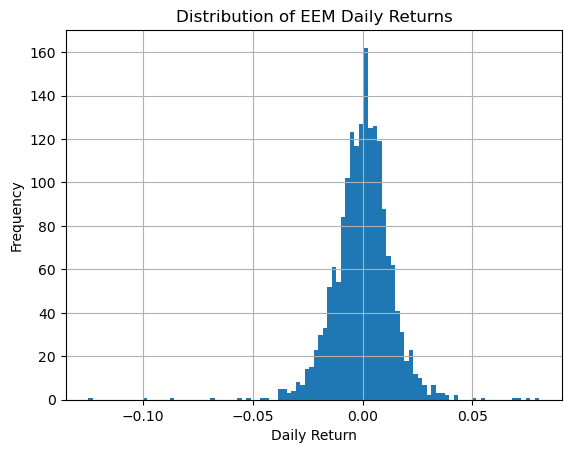

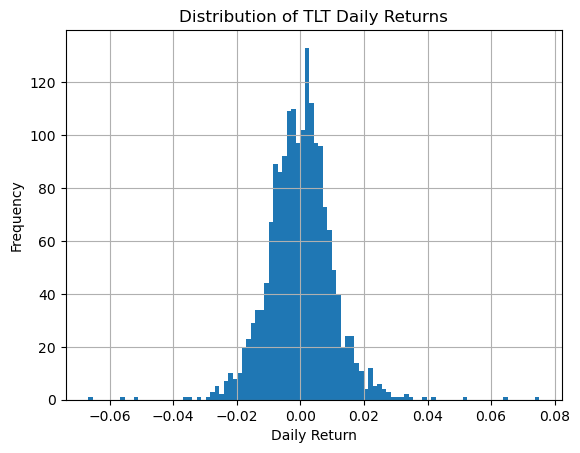

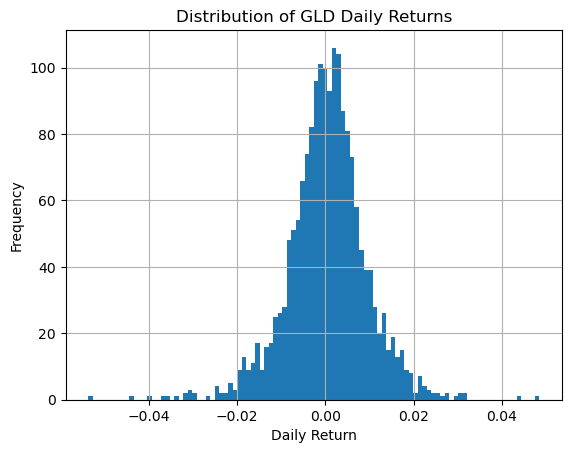

In [13]:
for ticker in tickers :
    daily_returns[f"{ticker}"].hist(bins = 100)
    plt.title(f"Distribution of {ticker} Daily Returns")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.show()


### 3.3 Scatter Plots

Examine the relationship between each factor (momentum, volatility, average volume) and the respective asset returns, identifying outliers or patterns.

We can see many outliers and high-leverage points.

C:\Users\kamiq\AppData\Local\Temp\ipykernel_30728\1836016384.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


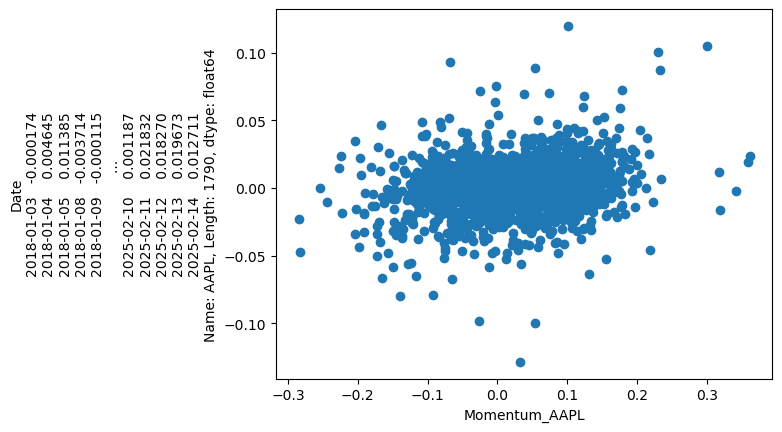

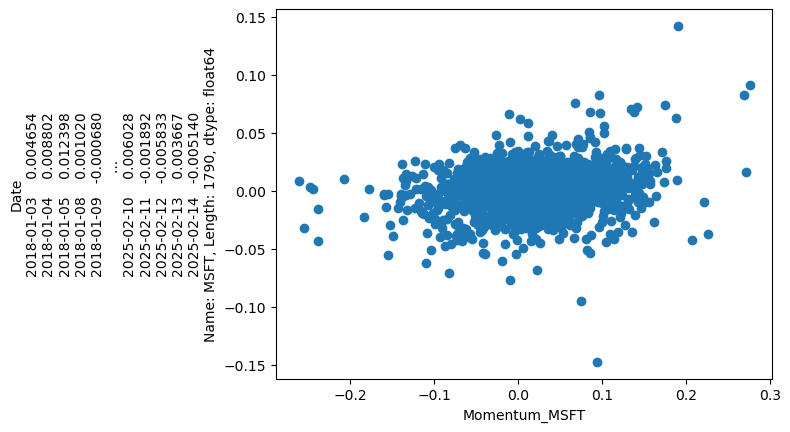

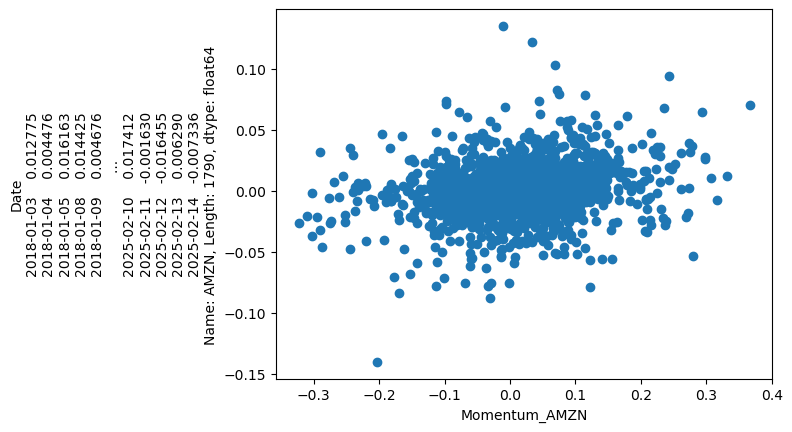

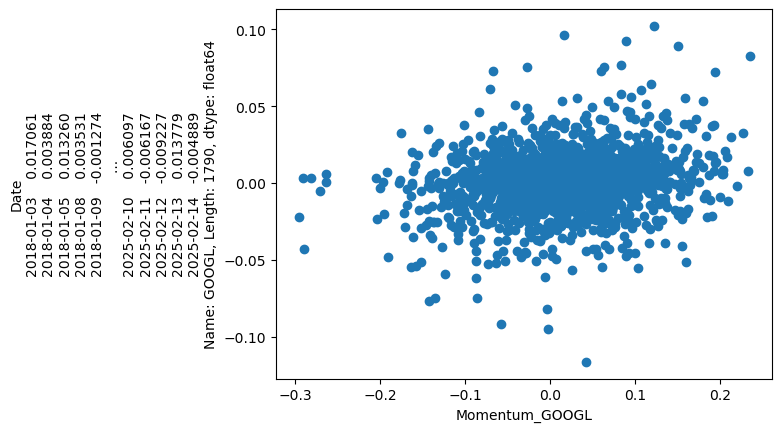

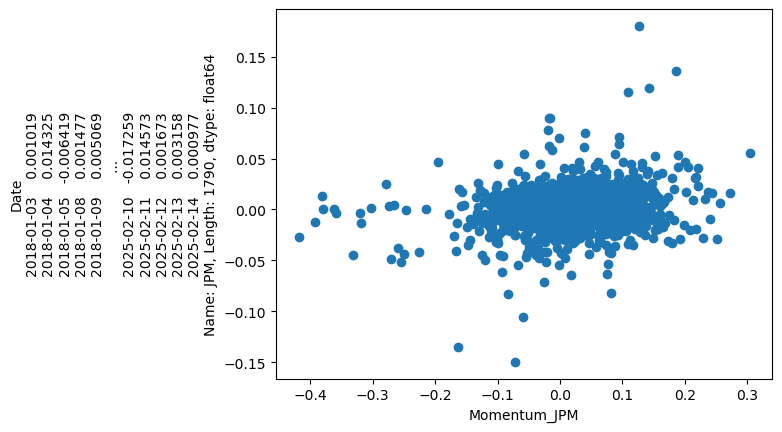

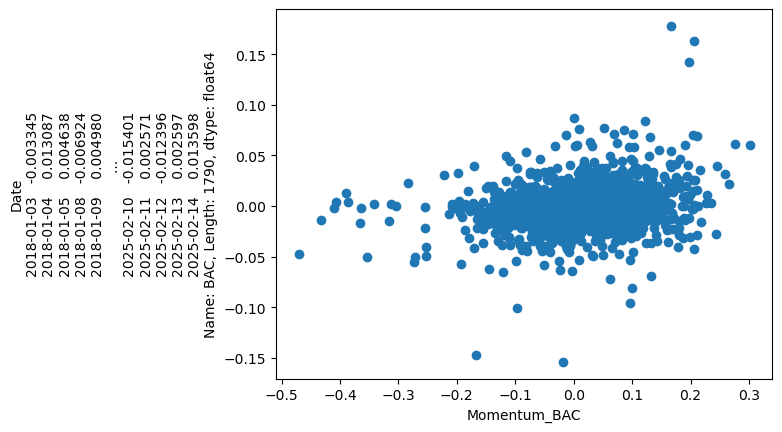

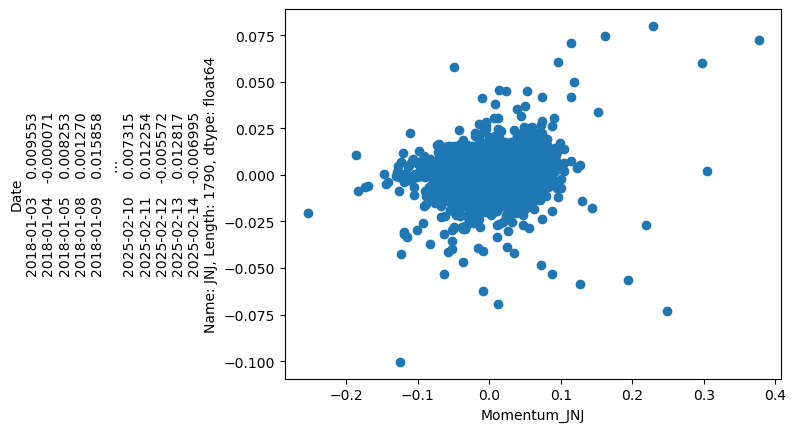

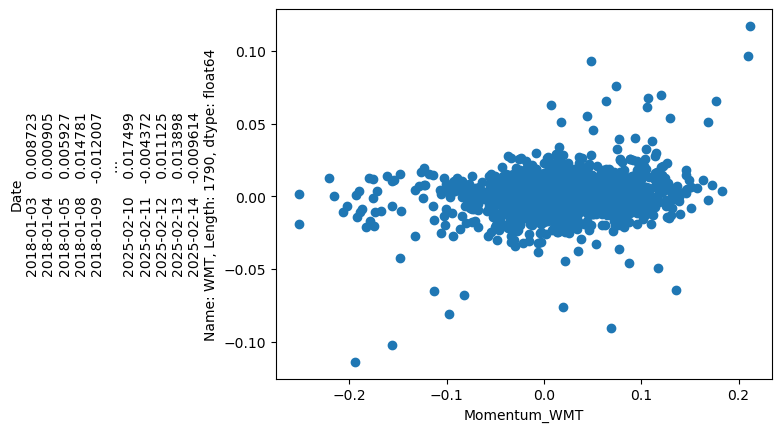

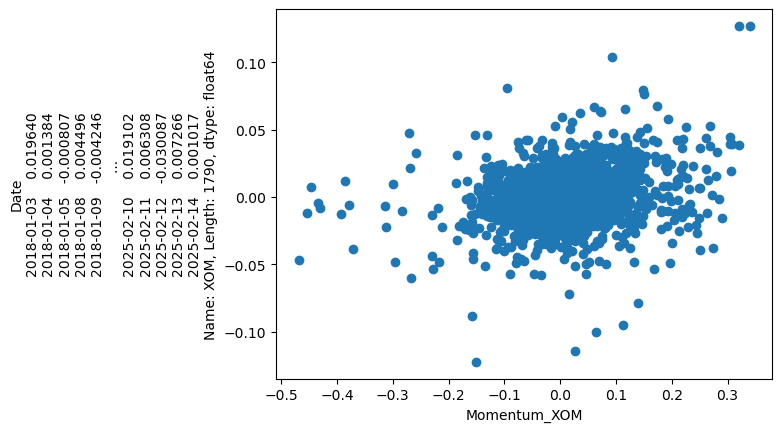

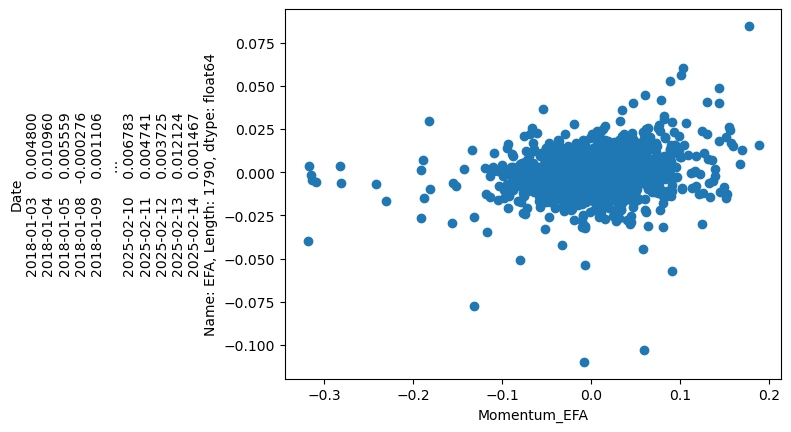

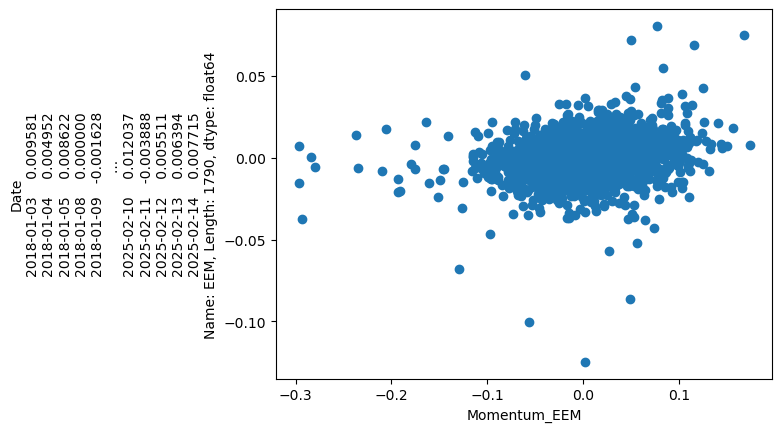

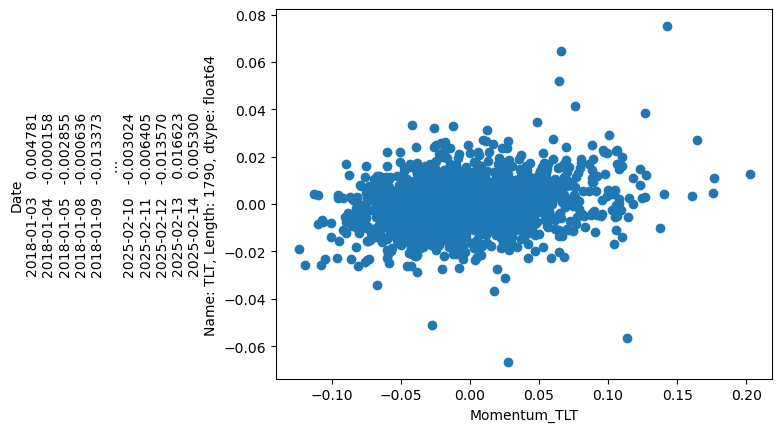

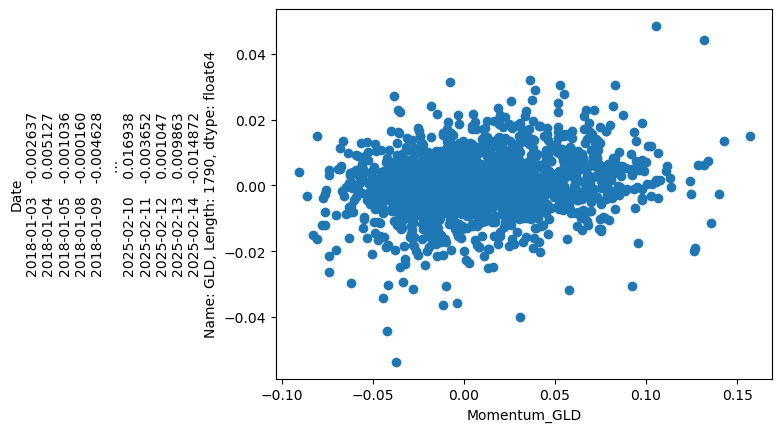

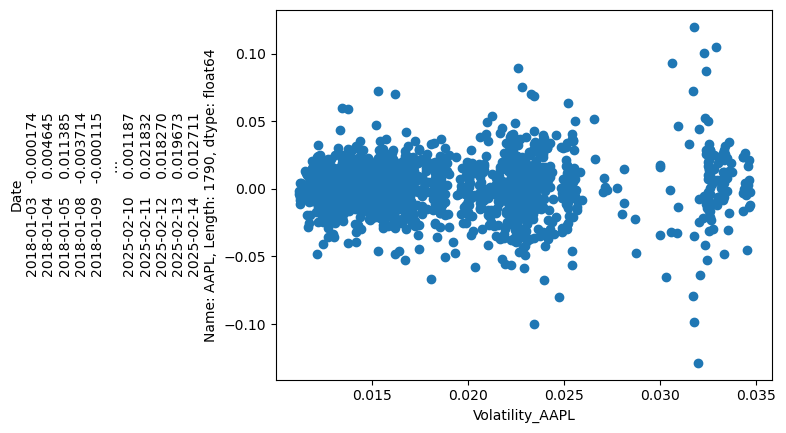

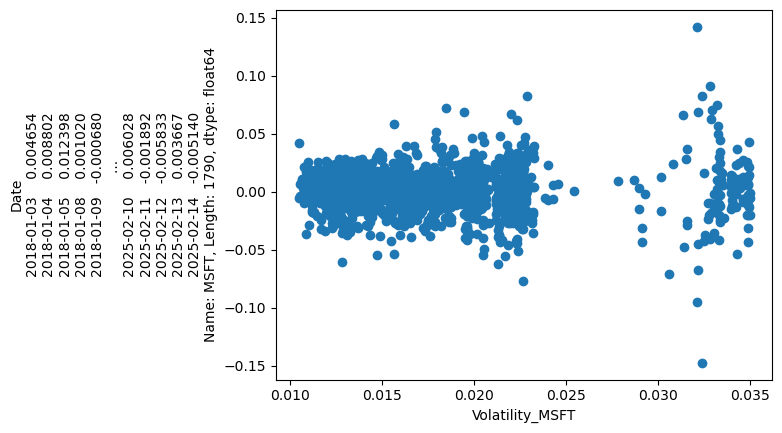

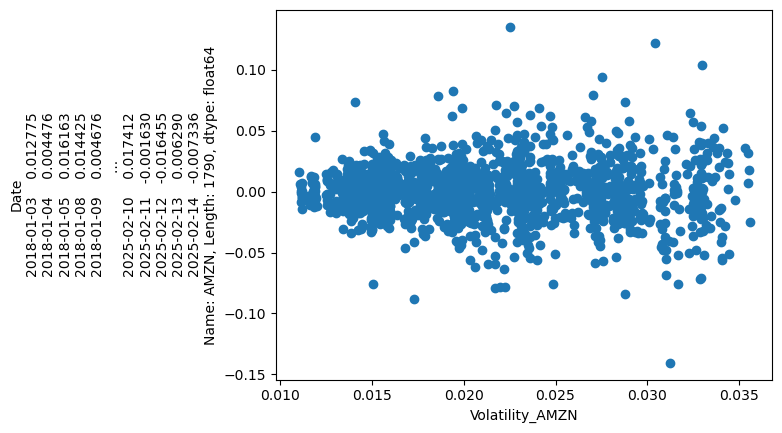

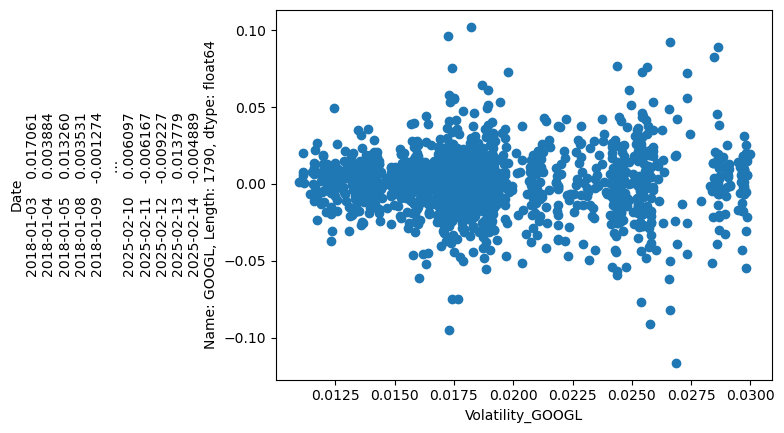

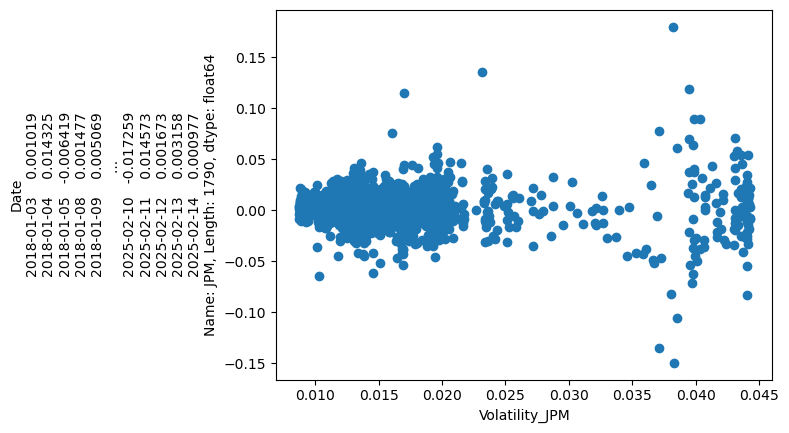

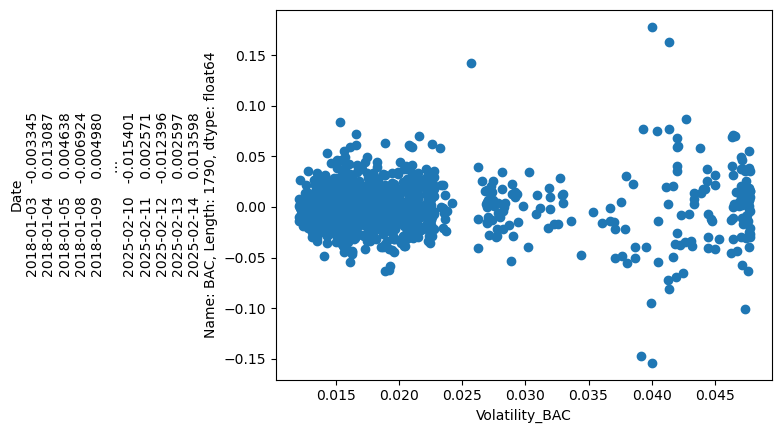

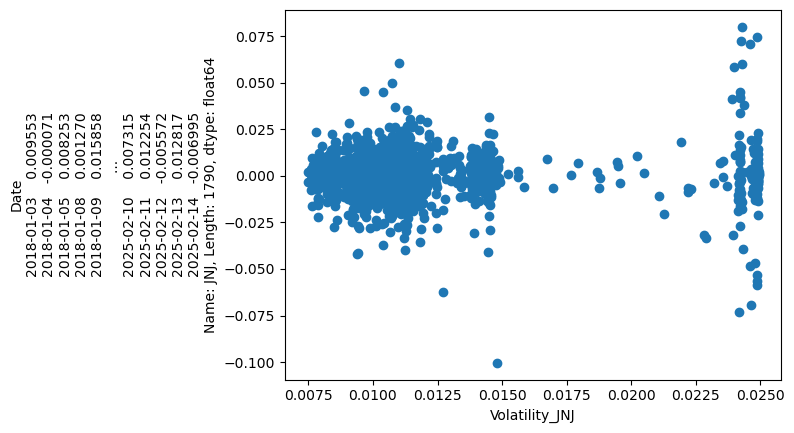

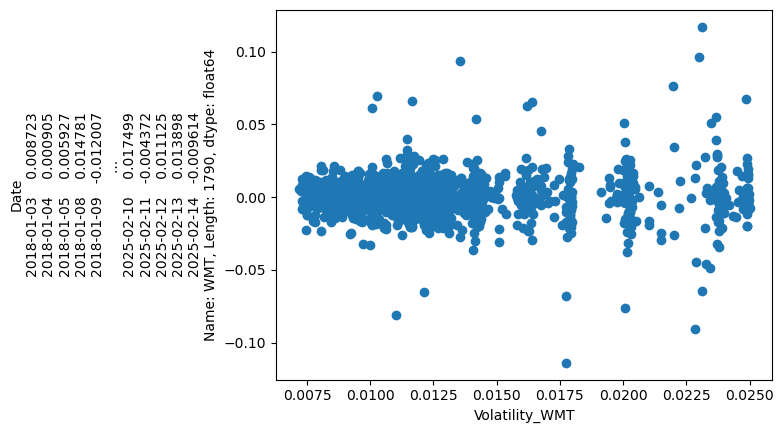

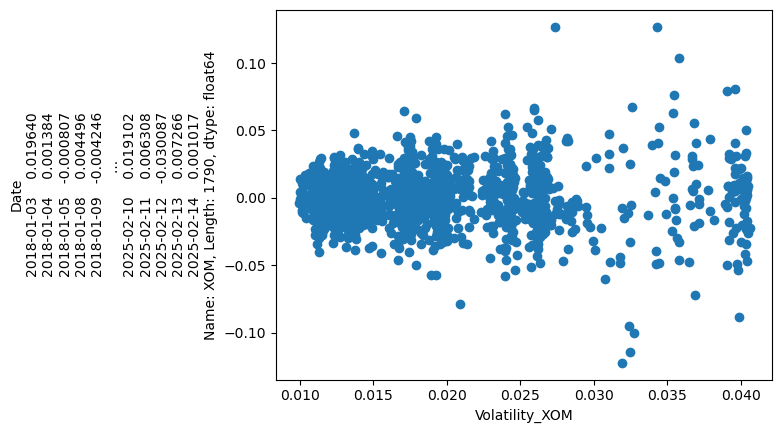

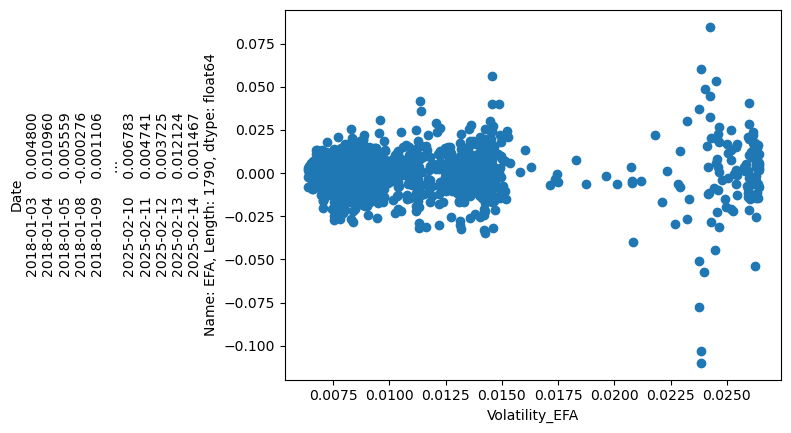

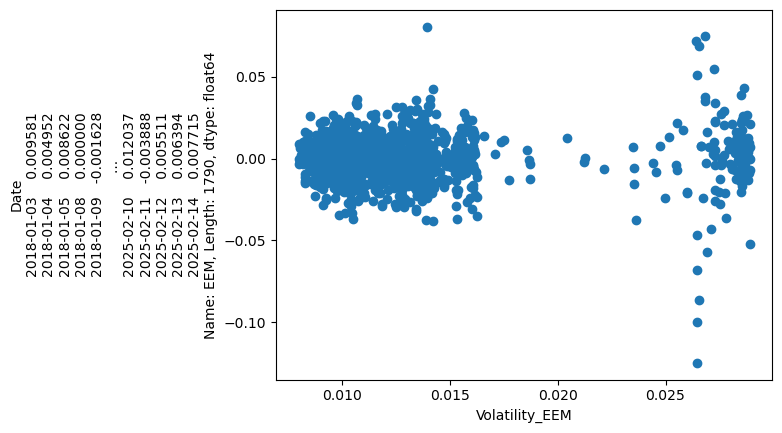

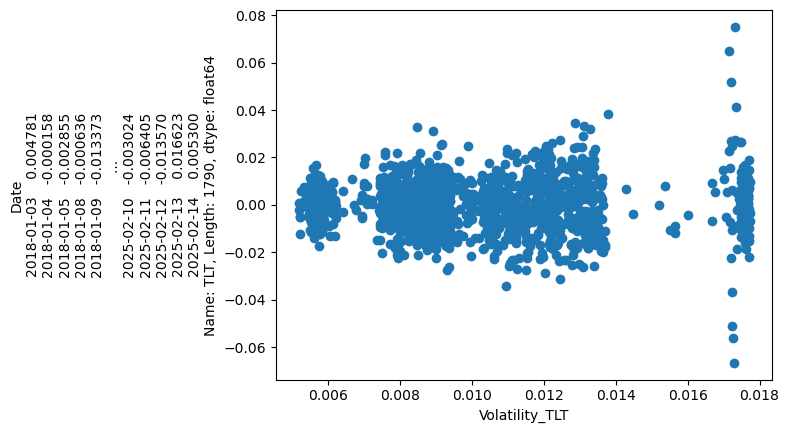

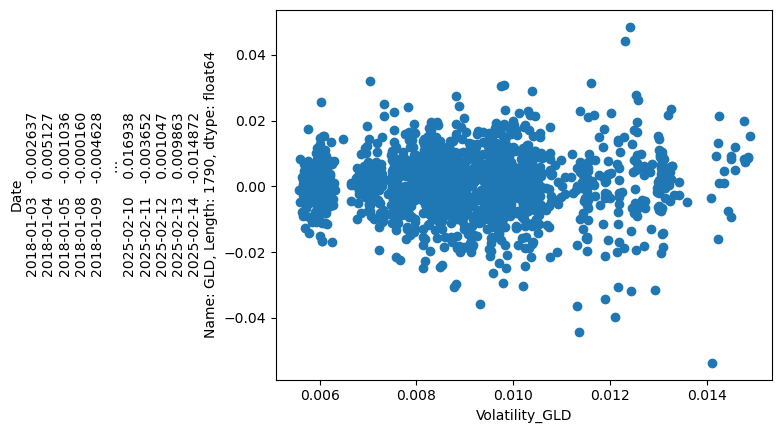

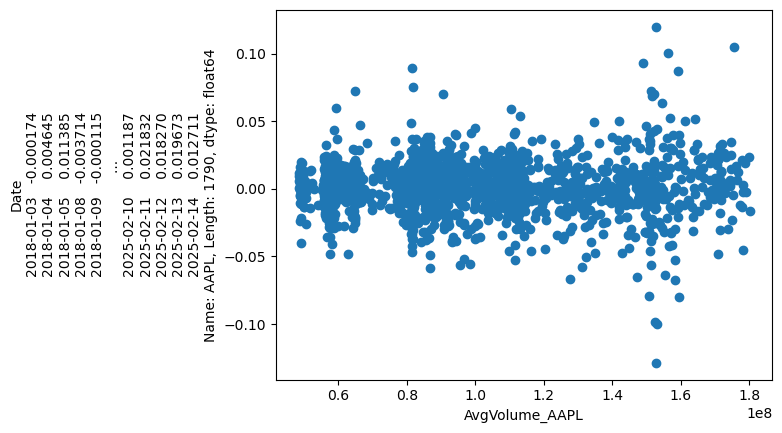

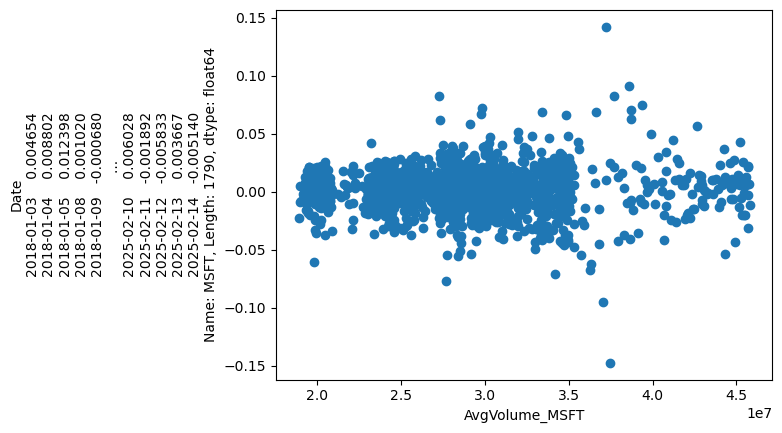

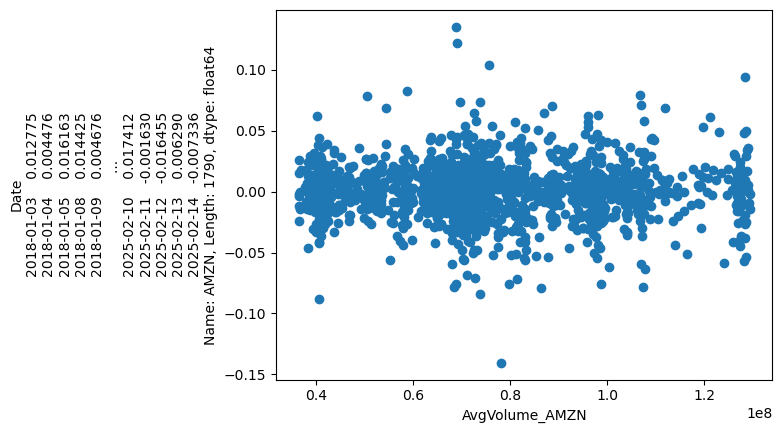

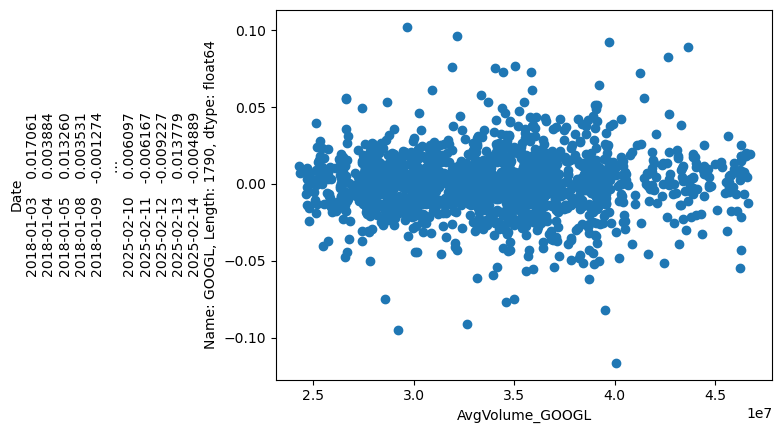

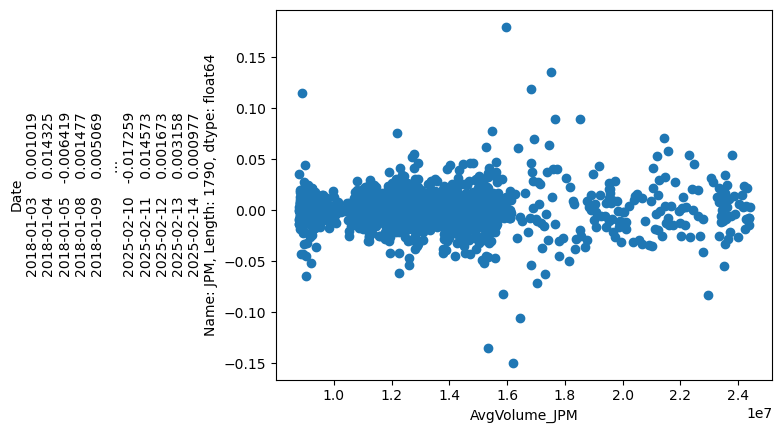

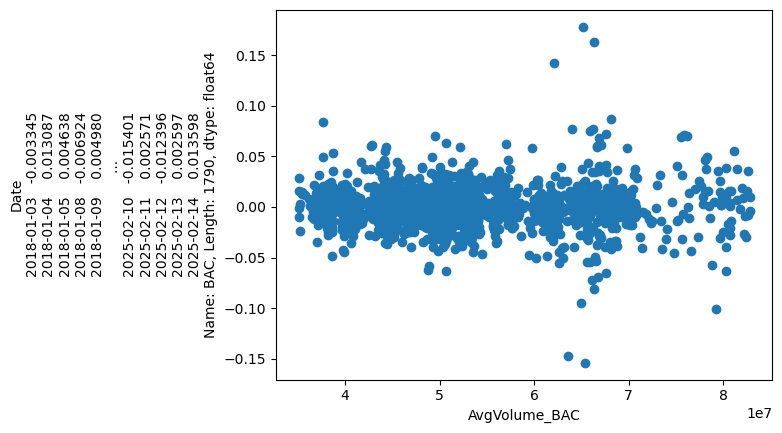

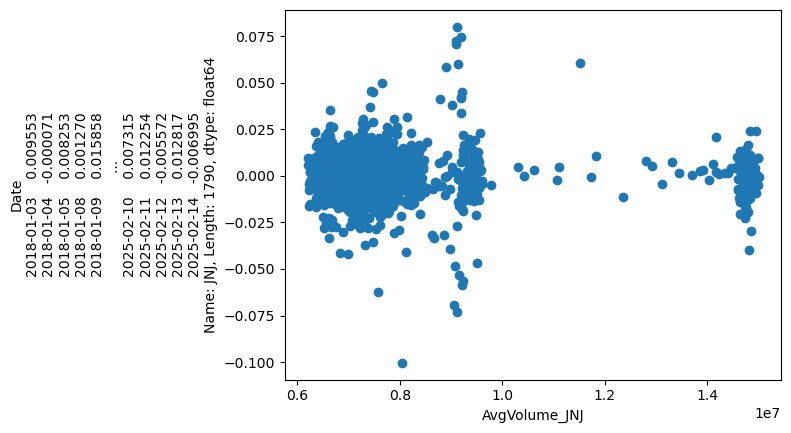

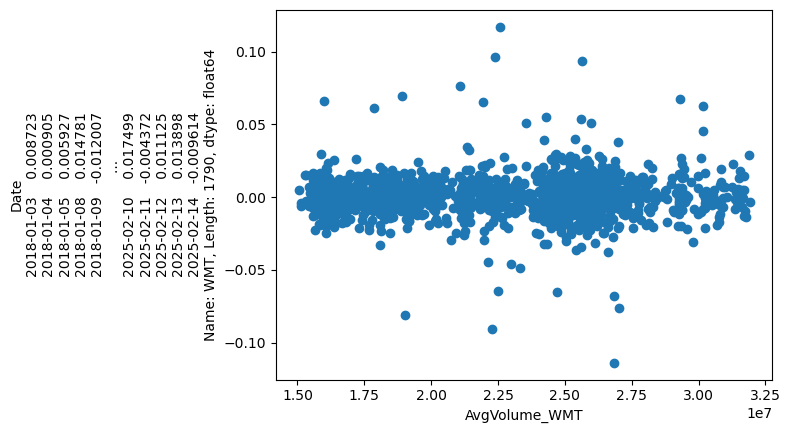

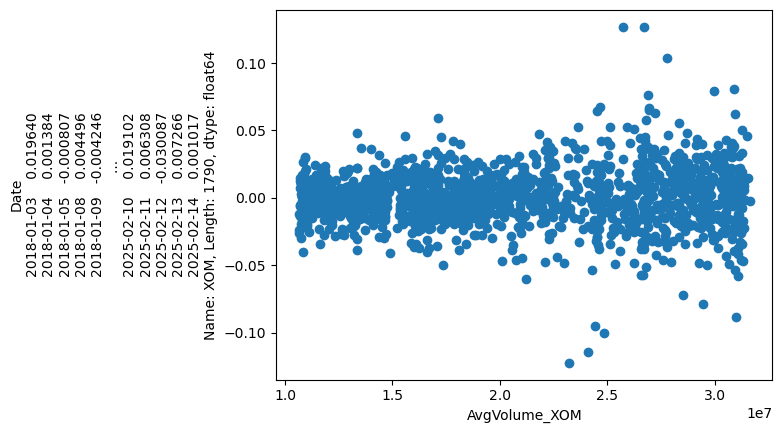

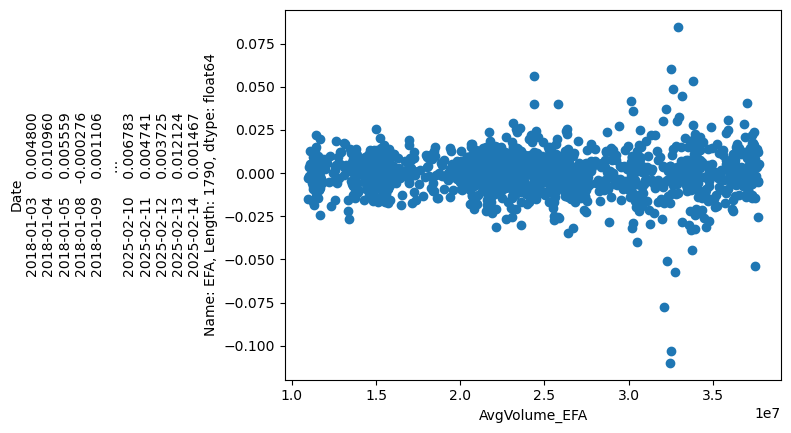

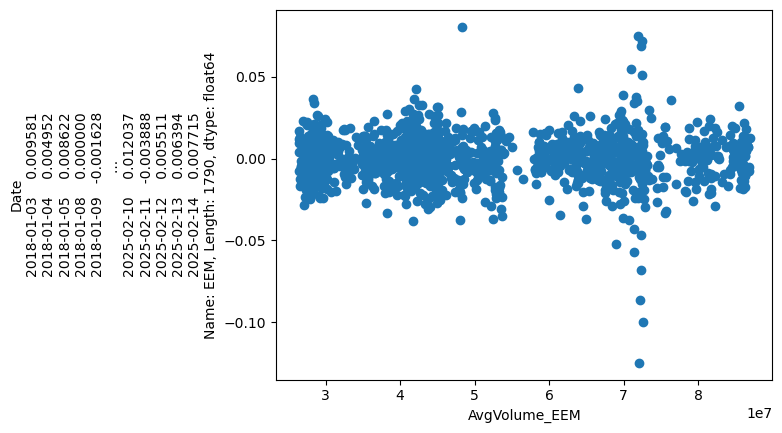

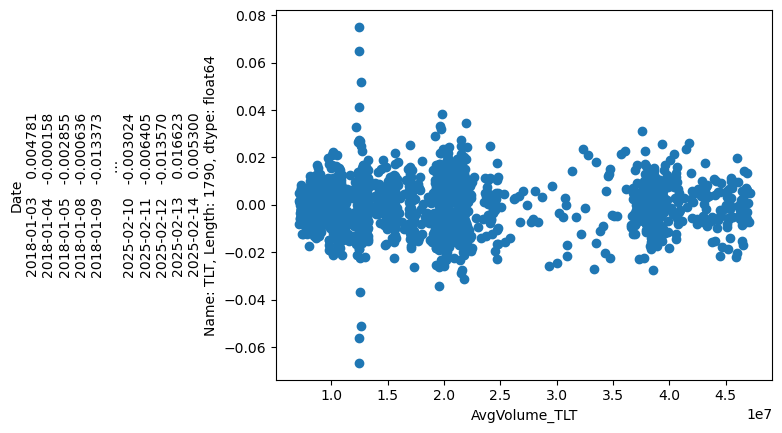

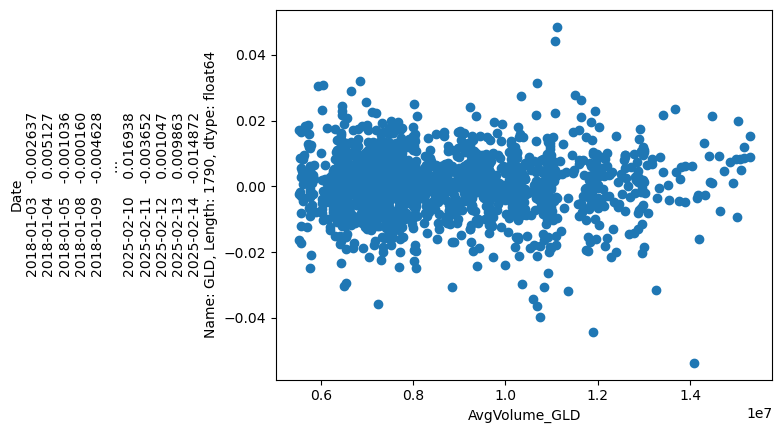

In [15]:
factors_list = ["Momentum", "Volatility", "AvgVolume"]
for factor in factors_list :
    for ticker in tickers :
        plt.figure()
        plt.scatter(factors_df[f"{factor}_{ticker}"], daily_returns[f"{ticker}"].shift(rebalance_period - 1).dropna())
        plt.xlabel(f"{factor}_{ticker}")
        plt.ylabel(daily_returns[f"{ticker}"])


### 4. Machine Learning-Based Return Forecasting

### 4.1 XGBoost Model

In [18]:
def train_predict_xgboost(feature_df, target_series):
    X_train = feature_df.iloc[:-1]
    y_train = target_series.iloc[:-1]
    X_current = feature_df.iloc[[-1]]
    
    model_xgb = xgb.XGBRegressor(objective = "reg:squarederror", n_estimators = 10, random_state = 42)
    model_xgb.fit(X_train, y_train)
    prediction = model_xgb.predict(X_current)[0]
    return prediction

## 5. Constructing Investor Views via Black-Litterman Framework

### 5.1 Compute $\Omega$ 

Calculate the view uncertainty (diagonal matrix) as $\Omega = diag(\tau \times P_i \times \Sigma \times P_i^T$) for each view row $i$ in $P$.

In [134]:
def compute_Omega(P, Sigma, tau):
    omega_diag = []
    for i in range(P.shape[0]):
        P_i = P[i, :]
        var_view = tau * (P_i @ Sigma @ P_i.T)
        omega_diag.append(var_view)
    return np.diag(omega_diag)

### 5.2 Compute $\mu_{BL}$ 

Compute Black-Litterman adjusted expected returns as 
$$
\mu_{BL} = \left[ (\tau \Sigma)^{-1} + P^T \Omega^{-1} P \right]^{-1} \left[ (\tau \Sigma)^{-1} \pi + P^T \Omega^{-1} Q \right]
$$

In [137]:
PERTURB_Q = False

def compute_mu_BL(pi, Sigma, P, Q, tau, Omega):
    """
    Compute Black-Litterman adjusted expected returns, optionally
    perturbing Q by ε ~ N(0, Ω_ii) when PERTURB_Q is True.
    """
    global PERTURB_Q
    
    # If flag is set, add elementwise noise to Q
    if PERTURB_Q:
        eps = np.random.normal(
            loc=0.0,
            scale=np.sqrt(np.diag(Omega)),
            size=Q.shape
        )
        Q = Q + eps

    inv_tauSigma = np.linalg.inv(tau * Sigma)
    inv_Omega    = np.linalg.inv(Omega)
    A = inv_tauSigma + P.T @ inv_Omega @ P
    B = inv_tauSigma @ pi      + P.T @ inv_Omega @ Q
    mu_BL = np.linalg.inv(A) @ B
    return mu_BL

### 5.3 Rule-based signal 

Construct a rule-based signal $Q_{rule}$, which will be used later to adjust $Q$ : For each asset, compare its AvgVolume with every other asset. 
If AvgVolume(asset) > AvgVolume(other), asset gets an advantage of (AvgVolume(asset)/AvgVolume(other)-1).

In [140]:
def rule_based_view(avgvol_series):
    tickers_local = avgvol_series.index.tolist()
    signals = {}
    for asset in tickers_local:
        advantages = []
        for other in tickers_local:
            if asset == other:
                continue
            if avgvol_series.loc[asset] > avgvol_series.loc[other]:
                advantages.append(avgvol_series.loc[asset] / avgvol_series.loc[other] - 1)
        signals[asset] = np.mean(advantages) if advantages else 0.0
    return pd.Series(signals)

## 5.4 Generate Views

**Assumption**: $P$ is the identity matrix for simplicity.

To compute the final view vector $Q$ at each rebalance:

1. **Machine Learning–Based Views** ($Q_{ml}$)  
   Use historical features (momentum, volatility, avg-volume) with an XGBoost regressor to predict each asset's forward return.

2. **Rule-Based Views** ($Q_{rule}$)  
   For each asset $i$, compare its avg-volume $v_i$ to every other $v_j$.  
   $$
     Q_{rule,i}
     = \frac{1}{N-1}\sum_{j\neq i}\Bigl(\tfrac{v_i}{v_j}-1\Bigr).
   $$

3. **Normalize & Weight**  
   Over the lookback window, z-score each view series:  
   $$
     Q^z_{ml,i} = \frac{Q_{ml,i}-\mu_{ml}}{\sigma_{ml}},\quad
     Q^z_{rule,i} = \frac{Q_{rule,i}-\mu_{rule}}{\sigma_{rule}}.
   $$  
   Compute in-sample MAE over the last $K = 5$ (error_window) rebalances for each signal against the **realized forward return**  
   $Q^{(t)}_{\text{true},i}$ (i.e.\ the actual portfolio excess return of asset $i$ from rebalance $t$ to $t+1$):  
   $$
     \mathrm{MAE}_{ml,i}
     = \frac{1}{K}\sum_{s=t-K+1}^t\bigl|Q^{(s)}_{ml,i}-Q^{(s)}_{\text{true},i}\bigr|,\quad
     \mathrm{MAE}_{rule,i}
     = \frac{1}{K}\sum_{s=t-K+1}^t\bigl|Q^{(s)}_{\text{rule},i}-Q^{(s)}_{\text{true},i}\bigr|.
   $$  
   Then  
   $$
     w_{ml,i}
     = \frac{1/\mathrm{MAE}_{ml,i}}{1/\mathrm{MAE}_{ml,i} + 1/\mathrm{MAE}_{rule,i}},\quad
     w_{rule,i} = 1 - w_{ml,i},
   $$  
   and  
   $$
     Q_{\text{comb},i} = w_{ml,i}\,Q^z_{ml,i} + w_{rule,i}\,Q^z_{rule,i}.
   $$

4. **Define and Smooth Alpha**  
   - Let $\alpha_t$ be the **realized annualized alpha** of our portfolio between rebalance $t-1$ and $t$ (computed by regressing portfolio excess returns on benchmark excess returns).  
   - Smooth $\alpha_t$ with an EWMA (with $\lambda = 0.9$):  
     $$
       \bar\alpha_t
       = \lambda\,\bar\alpha_{t-1} + (1-\lambda)\,\alpha_t,
       \quad\bar\alpha_0=\alpha_0.
     $$  
     Here $\bar\alpha_t$ is the **smoothed alpha** at rebalance $t$.

5. **Calibrate Adjustment Factors**  
   Split the history of rebalance dates into train/test (70%/30%):

   - On the train set, search for up/down multipliers $(u,d)$ (we impose the constraints $1.0\leq u\leq 5.0$ and $0.1\leq d\leq 1.0$) that maximize average $\bar\alpha_t$.

7. **Final $Q$ Adjustment**  
   Compute the change $\Delta\bar\alpha = \bar\alpha_t - \bar\alpha_{t-1}$. Then  
   $$
     Q_i =
     \begin{cases}
       u\,e^{\Delta\bar\alpha}\;Q_{\text{comb},i}, & \Delta\bar\alpha>0,\\
       d\,e^{\Delta\bar\alpha}\;Q_{\text{comb},i}, & \Delta\bar\alpha<0,\\
       Q_{\text{comb},i}, & \Delta\bar\alpha=0.
     \end{cases}
   $$  
   Here $u$ and $d$ are the calibrated “risk-aversion” factors.


In [316]:
# === Helpers ===
def _zscore(series, lookback):
    return (series - series.rolling(lookback).mean()) / series.rolling(lookback).std()

def _combine_Q(Q_ml, Q_rule, lookback, error_window = 5):
    Q_ml_z = _zscore(Q_ml, lookback)
    Q_rule_z = _zscore(Q_rule, lookback)
    Q_true = Q_ml.shift(-1)
    mae_ml = (Q_true - Q_ml).abs().rolling(error_window).mean()
    mae_rule = (Q_true - Q_rule).abs().rolling(error_window).mean()
    inv_ml = 1 / mae_ml
    inv_rule = 1 / mae_rule
    w_ml = inv_ml/ (inv_ml + inv_rule)
    w_rule = inv_rule / (inv_ml + inv_rule)
    return w_ml * Q_ml_z + w_rule * Q_rule_z

def _ewma(series, lam = 0.9):
    return series.ewm(alpha= 1 - lam, adjust = False).mean()

def _calibrate_factors(alpha_series, rebalance_dates, train_frac = 0.7):
    split = int(len(rebalance_dates) * train_frac)
    train_idx = rebalance_dates[:split]
    def loss(params):
        u,d = params
        alpha_ewm = _ewma(alpha_series)
        prev = alpha_ewm.iloc[0]
        adj = []
        for val in alpha_ewm:
            delta = val - prev
            adj.append((u * np.exp(delta)) if delta > 0 else (d * np.exp(delta)) if delta < 0 else 1)
            prev = val
        arr = np.array(adj)
        mask = alpha_series.index.isin(train_idx)
        return -np.nanmean(arr[mask])
    res = sco.minimize(loss, [2.0, 0.75], bounds=[(1, 5), (0.1 , 1)])
    return res.x

# Globals for adjustment factors (to be set after calibration)
UP_FACTOR = 2.0
DOWN_FACTOR = 0.75

def construct_views_at_date(rebalance_date, factors_df, lookback, rebalance_period):
    # Machine learning views
    Q_ml = {}
    for ticker in tickers:
        feat_cols = [f"Momentum_{ticker}", f"Volatility_{ticker}", f"AvgVolume_{ticker}"]
        df_asset = factors_df.loc[:rebalance_date, feat_cols].tail(lookback)
        target = df_asset[f"Momentum_{ticker}"].shift(-rebalance_period)
        valid = df_asset.index.intersection(target.dropna().index)
        df_asset = df_asset.loc[valid]
        target = target.loc[valid]
        if len(df_asset) < 10:
            Q_ml[ticker] = 0.0
        else:
            Q_ml[ticker] = train_predict_xgboost(df_asset, target)
    Q_ml = pd.Series(Q_ml)

    # Rule-based views
    avgvol = {t: factors_df.loc[:rebalance_date, f"AvgVolume_{t}"].tail(lookback).mean()
              for t in tickers}
    rule_signal = rule_based_view(pd.Series(avgvol))
    Q_rule = rule_signal

    # Combine normalized and weighted
    Q_combined = _combine_Q(Q_ml, Q_rule, lookback)

    # Identity P
    P = np.eye(len(tickers))
    Q = Q_combined.values
    return P, Q

### 5.5 Compute final $Q$

In [307]:
def adjust_Q(Q, portfolio_alpha_history, prev_portfolio_alpha):
    # extract a numeric series of annualized alpha
    dates  = list(portfolio_alpha_history.keys())
    alphas = [portfolio_alpha_history[d]['annualized_alpha'] for d in dates]
    alpha_ewm = pd.Series(alphas, index = dates).ewm(alpha = 0.1).mean()
    # if we don’t have two points yet, skip adjustment
    if len(alpha_ewm) < 2:
        return Q
    delta = alpha_ewm.iloc[-1] - alpha_ewm.iloc[-2]
    factor = UP_FACTOR * np.exp(delta) if delta > 0 else DOWN_FACTOR * np.exp(delta) if delta < 0 else 1.0
    return Q * factor

## 6. Portfolio Optimization

- Optimization Setup :
    Formulate an optimization problem targeting the maximization of the portfolio Sharpe ratio.

- Constraints :
    - Budget Constraint :
        The sum of portfolio weights equals 1.
    - No Short-Selling :
        Each weight is within the interval [0, 1].
    - Variance Constraint :
        The portfolio variance must be below a specified target ($V_{target} = 0.0005$).
    - Concentration Constraint :
        Herfindahl-Hirschman Index (HHI) must be below a specified threshold ($\text{HHI}_{target} = 0.2$).
          $$ \text{HHI} = \sum_{i \in \text{tickers}} w_i^2. $$


- Solve the Optimization :
    - Optimize portfolio weights using the derived adjusted expected returns and computed covariance matrix.

In [204]:
V_target = 0.0005
HHI_target = 2 / len(tickers)

def optimize_portfolio(mu, Sigma, risk_free_rate_daily):
    n = len(mu)
    
    def neg_sharpe(w):
        w = np.array(w)
        ret = w.dot(mu)
        vol = np.sqrt(w.T.dot(Sigma).dot(w))
        sharpe = (ret - risk_free_rate_daily) / vol
        return -sharpe

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1}, # Linear constraint: sum of weights is 1.
        {"type": "ineq", "fun": lambda w: V_target - w.T.dot(Sigma).dot(w)}, # Non-linear constraint: portfolio variance is less than or equal to V_target.
        {"type": "ineq", "fun": lambda w: HHI_target - np.sum(w**2) } # Non-linear constraint: portfolio's HHI is less or equal to HHI_target.
    ]
    
    bounds = tuple((0, 1) for _ in range(n))
    w0 = np.array([1/n] * n)
    
    result = sco.minimize(neg_sharpe, w0, method = "SLSQP", bounds = bounds, constraints = constraints)
    return result.x


## 7. Backtesting

### 7.1 Benchmark(S&P500) data

In [208]:
benchmark = yf.download(["^GSPC"], start = "2018-01-01", end = "2025-02-15", auto_adjust = False)
benchmark_adj_close = benchmark["Adj Close"].dropna()
benchmark_returns = benchmark_adj_close.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


### 7.2 Rolling Simulation

My strategy is to dynamically readjust the portfolio. I hold the portfolio, and readjust it once every 21 days, based on the its previous performance and market's performance for the last 126 days.

For each rebalancing period:
- Compute the covariance matrix and equilibrium returns.
- Construct investor views and compute adjusted expected returns.
- Optimize portfolio weights.
- Account for transaction costs.
- Evaluate performance in the following period.
- Store performance metrics and update portfolio weights.

We use $\tau$ = constant 0.025. This is a common practice.

In [319]:
# I use US 10 Year Treasury Rate at 2015, converted to daily rate
risk_free_rate_annual = 0.04
risk_free_rate_daily  = risk_free_rate_annual / 252

# Run one pass
def _run_sim(tau, adjust):
    pw_hist   = {}; pa_hist = {}; mu_hist = {}; tc_hist = {}
    prev_w    = np.array([1/len(tickers)] * len(tickers))
    prev_a    = 0.0; prev2_a = 0.0
    dates     = daily_returns.iloc[lookback::rebalance_period].index

    for date in dates:
        Sigma      = daily_returns.loc[:date].tail(lookback).cov().values
        pi_vec     = tau * (Sigma @ prev_w)
        P, Q_raw   = construct_views_at_date(date, factors_df, lookback, rebalance_period)
        Q_used     = adjust_Q(Q_raw, pa_hist, prev_a) if adjust else Q_raw
        Omega      = compute_Omega(P, Sigma, tau)
        mu_BL      = compute_mu_BL(pi_vec, Sigma, P, Q_used, tau, Omega)
        w_opt      = optimize_portfolio(mu_BL, Sigma, risk_free_rate_daily)
        turnover   = np.sum(np.abs(w_opt - prev_w))
        tc_hist[date] = turnover * 0.001

        pw_hist[date] = w_opt; mu_hist[date] = mu_BL

        idx = daily_returns.index.get_loc(date)
        if idx + rebalance_period < len(daily_returns.index):
            end = daily_returns.index[idx + rebalance_period]
            pr  = daily_returns.loc[date:end].dot(w_opt)
            br  = benchmark_returns.loc[date:end]
            common = pr.index.intersection(br.index)
            ex_p   = pr.loc[common] - risk_free_rate_daily
            ex_b   = br.loc[common] - risk_free_rate_daily
            reg    = LinearRegression().fit(ex_b.values.reshape(-1,1), ex_p.values)
            a_d    = reg.intercept_; b = reg.coef_[0]
            ann_a  = (1 + a_d) ** 252 - 1
        else:
            a_d, b, ann_a = np.nan, np.nan, np.nan

        pa_hist[date] = {'alpha_daily' : a_d, 'beta' : b, 'annualized_alpha' : ann_a}
        prev2_a, prev_a, prev_w = prev_a, ann_a if not np.isnan(ann_a) else prev_a, w_opt

    pw_df = pd.DataFrame(pw_hist).T
    pa_df = pd.DataFrame(pa_hist).T; mu_df = pd.DataFrame(mu_hist).T
    tc_sr = pd.Series(tc_hist)

    all_pr = pd.concat([
        daily_returns.loc[d:(dates[i+1] if i < len(dates)-1 else daily_returns.index[-1])]
        .dot(pw_df.loc[d].values)
        for i, d in enumerate(dates)
    ])
    idx = all_pr.index.unique().intersection(benchmark_returns.index.unique())
    pdr = all_pr.loc[idx]; bdr = benchmark_returns.loc[idx]
    port_cum  = (1 + pdr).cumprod() - 1
    bench_cum = (1 + bdr).cumprod() - 1

    return {
        'portfolio_weights_df': pw_df,
        'portfolio_alpha_df':   pa_df,
        'mu_BL_df':             mu_df,
        'transaction_cost_df':  tc_sr,
        'portfolio_cum_returns':  port_cum,
        'benchmark_cum_returns':  bench_cum,
        'portfolio_daily_returns_aligned': pdr,
        'benchmark_daily_returns_aligned': bdr
    }

def Monte_Carlo_simulate(tau):
    # 1) gather alphas without adjustment
    temp = _run_sim(tau, adjust = False)
    alphas = temp['portfolio_alpha_df']['annualized_alpha']
    dates  = alphas.index.tolist()
    # 2) calibrate factors
    u, d = _calibrate_factors(alphas, dates, train_frac = 0.7)
    global UP_FACTOR, DOWN_FACTOR
    UP_FACTOR, DOWN_FACTOR = u, d
    # 3) final run with adjustment
    return _run_sim(tau, adjust = True)

### 7.3 Run the simulation

In [278]:
result = Monte_Carlo_simulate(tau)
print("Final cumulative return :", result['portfolio_cum_returns'].iloc[-1])

Final cumulative return : 2.0483581446176857


## 8. Performance Evaluation and Metrics Calculation

We compute :
- Cumulative Returns
- Annualized return and volatility.
- Sharpe Ratio.
- Maximum drawdown.
- VaR and CVaR (95%)

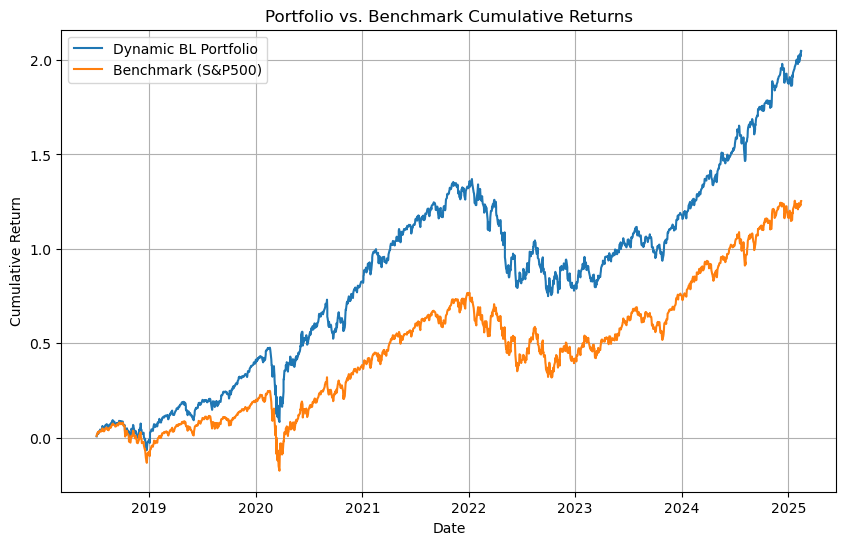


Portfolio Alpha/Beta History (first 5 dates):
            alpha_daily      beta  annualized_alpha
2018-07-05     0.000803  0.886783          0.224125
2018-08-03    -0.000235  1.133215         -0.057497
2018-09-04    -0.000379  1.028426         -0.091139
2018-10-03     0.000506  0.879608          0.135987
2018-11-01    -0.000262  0.976360         -0.063999


In [293]:
# Extract cumulative returns for portfolio and benchmark.
portfolio_cum_returns = result["portfolio_cum_returns"]
benchmark_cum_returns = result["benchmark_cum_returns"]


# Plot Cumulative Returns
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cum_returns.index, portfolio_cum_returns, label = "Dynamic BL Portfolio")
plt.plot(benchmark_cum_returns.index, benchmark_cum_returns, label = "Benchmark (S&P500)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Portfolio vs. Benchmark Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()


portfolio_alpha_df = result["portfolio_alpha_df"]

print("\nPortfolio Alpha/Beta History (first 5 dates):")
print(portfolio_alpha_df.head())

In [283]:
def compute_performance_metrics(returns, risk_free_rate_daily, risk_free_rate_annual, confidence_level = 0.95):
    # Ensure returns is a Series 
    if isinstance(returns, pd.DataFrame):
        returns = returns.squeeze()
    
    cumulative_return = np.prod(1 + returns) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate_annual) / annualized_vol

    
    cum_returns = (1 + returns).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns - running_max) / running_max
    max_drawdown = drawdown.min()

    # Compute VaR and CVaR
    var = returns.quantile(1 - confidence_level)
    cvar = returns[returns <= var].mean()

    metrics = {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_vol,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "VaR (95%)": var,
        "CVaR (95%)": cvar
    }
    return metrics



portfolio_daily_returns_aligned = result["portfolio_daily_returns_aligned"]
benchmark_daily_returns_aligned = result["benchmark_daily_returns_aligned"]

portfolio_metrics = compute_performance_metrics(portfolio_daily_returns_aligned, risk_free_rate_daily, risk_free_rate_annual)
benchmark_metrics = compute_performance_metrics(benchmark_daily_returns_aligned, risk_free_rate_daily, risk_free_rate_annual)

print("Portfolio Performance Metrics:")
for key, value in portfolio_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nS&P500 Benchmark Performance Metrics:")
for key, value in benchmark_metrics.items():
    print(f"{key}: {value:.4f}")

Portfolio Performance Metrics:
Cumulative Return: 2.0484
Annualized Return: 0.1749
Annualized Volatility: 0.1656
Sharpe Ratio: 0.8144
Max Drawdown: -0.2667
VaR (95%): -0.0154
CVaR (95%): -0.0245

S&P500 Benchmark Performance Metrics:
Cumulative Return: 1.2536
Annualized Return: 0.1309
Annualized Volatility: 0.1985
Sharpe Ratio: 0.4581
Max Drawdown: -0.3392
VaR (95%): -0.0184
CVaR (95%): -0.0301


## 9. Portfolio's alpha and beta relative to the benchmark

In [286]:
portfolio_excess = portfolio_daily_returns_aligned - risk_free_rate_daily
benchmark_excess = benchmark_daily_returns_aligned - risk_free_rate_daily

# Align the two series 
df_excess = pd.concat([portfolio_excess, benchmark_excess], axis = 1).dropna()
df_excess.columns = ["portfolio_excess", "benchmark_excess"]

X = df_excess[["benchmark_excess"]].values  # Predictor (2D array)
y = df_excess["portfolio_excess"].values      # Response (1D array)

model_lin = LinearRegression().fit(X, y)

alpha_daily = model_lin.intercept_
beta = model_lin.coef_[0]

# Annualize the daily alpha  
alpha_annual = (1 + alpha_daily) ** 252 - 1

print("Portfolio Beta: {:.4f}".format(beta))
print("Portfolio Daily Alpha: {:.6f}".format(alpha_daily))
print("Portfolio Annualized Alpha: {:.4f}".format(alpha_annual))

Portfolio Beta: 0.7925
Portfolio Daily Alpha: 0.000145
Portfolio Annualized Alpha: 0.0372


## 10. Hypothesis Testing for Outperformance

We compute the daily difference between portfolio and benchmark, and perform a t-test on performance metrics

In [289]:
# Clean & align the two return series
port = (portfolio_daily_returns_aligned.dropna().loc[~portfolio_daily_returns_aligned.index.duplicated(keep='first')])
bench = (benchmark_daily_returns_aligned.dropna().loc[~benchmark_daily_returns_aligned.index.duplicated(keep='first')])
common_idx = port.index.intersection(bench.index)
port = port.loc[common_idx]
bench = bench.loc[common_idx]

# Rebalance dates
rebalance_dates = daily_returns.iloc[lookback::rebalance_period].index

# Containers to hold one sample per window for each metric except daily return
samples = {
    "port_VaR": [],    "bench_VaR": [],
    "port_CVaR": [],   "bench_CVaR": [],
    "port_MDD": [],    "bench_MDD": [],
    "port_Sharpe": [], "bench_Sharpe": []
}

# Loop over each rebalance date => take the preceding "lookback" days as one sample
for date in rebalance_dates:
    if date not in port.index:
        continue
    idx = port.index.get_loc(date)
    if idx - lookback + 1 < 0:
        continue

    window_idx = port.index[idx - lookback + 1 : idx + 1]
    port_win = port.loc[window_idx]
    bench_win = bench.loc[window_idx]

    # Compute performance metrics on this window
    pm = compute_performance_metrics(port_win,risk_free_rate_daily,risk_free_rate_annual)
    bm = compute_performance_metrics(bench_win,risk_free_rate_daily,risk_free_rate_annual)

    # Collect metrics
    samples["port_VaR"].append(pm["VaR (95%)"])
    samples["bench_VaR"].append(bm["VaR (95%)"])
    samples["port_CVaR"].append(pm["CVaR (95%)"])
    samples["bench_CVaR"].append(bm["CVaR (95%)"])
    samples["port_MDD"].append(pm["Max Drawdown"])
    samples["bench_MDD"].append(bm["Max Drawdown"])
    samples["port_Sharpe"].append(pm["Sharpe Ratio"])
    samples["bench_Sharpe"].append(bm["Sharpe Ratio"])

# Paired t‑tests on each windowed metric
for m_label, metric_name in [
    ("VaR", "VaR (95%)"),
    ("CVaR", "CVaR (95%)"),
    ("MDD", "Max Drawdown"),
    ("Sharpe", "Sharpe Ratio"),
]:
    a = np.array(samples[f"port_{m_label}"])
    b = np.array(samples[f"bench_{m_label}"])

    # Truncate to same length and drop NaNs
    n = min(len(a), len(b))
    a, b = a[:n], b[:n]
    mask = ~np.isnan(a) & ~np.isnan(b)
    a, b = a[mask], b[mask]

    if len(a) < 2:
        print(f"{metric_name}: not enough data for t-test\n")
        continue

    t_stat, p_value = stats.ttest_rel(a, b)
    print(f"{metric_name}:")
    print(f"  Portfolio mean = {a.mean():.4f}, Benchmark mean = {b.mean():.4f}")
    print(f"  t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    print("  =>", 
          "significant difference" if p_value < 0.05 else "no significant difference",
          "\n")



VaR (95%):
  Portfolio mean = -0.0154, Benchmark mean = -0.0189
  t-statistic = 10.3631, p-value = 0.0000
  => significant difference 

CVaR (95%):
  Portfolio mean = -0.0216, Benchmark mean = -0.0261
  t-statistic = 11.4383, p-value = 0.0000
  => significant difference 

Max Drawdown:
  Portfolio mean = -0.0962, Benchmark mean = -0.1185
  t-statistic = 8.6913, p-value = 0.0000
  => significant difference 

Sharpe Ratio:
  Portfolio mean = 1.1603, Benchmark mean = 0.9066
  t-statistic = 5.8706, p-value = 0.0000
  => significant difference 



## 11. Sensitivity Analysis with Monte Carlo Simulation

What is parameter sensitivity analysis ? Instead of evaluating our strategy at just a fixed value of $\tau$, $\delta$, or other varaibles, we can simulate many scenarios in which these parameters vary randomly within realistic ranges. This also helps us understand the stability of our model.

Here we test our model with different values of $\tau$.

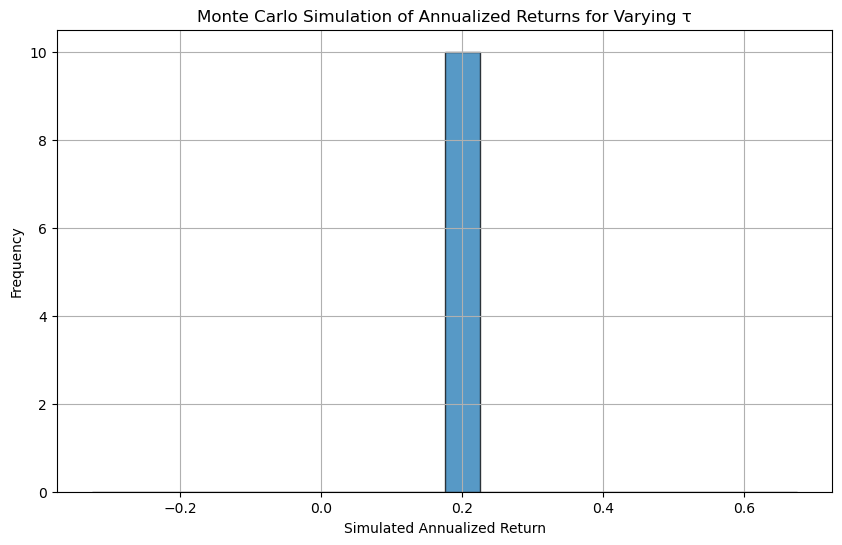

Monte Carlo Simulation Summary for Annualized Returns:
Mean Annualized Return: 0.1749
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.1749
Max Annualized Return: 0.1749


In [301]:
n_simulations = 10 
tau_samples = np.random.uniform(0.015, 0.035, n_simulations)

annualized_returns = []

for tau in tau_samples:
    # Run the simulation with the current tau.
    result = Monte_Carlo_simulate(tau)
    portfolio_cum_returns = result["portfolio_cum_returns"]  
    
    n_trading_days = len(portfolio_cum_returns)
    final_cum_return = portfolio_cum_returns.iloc[-1]
    annualized_return = (1 + final_cum_return) ** (252 / n_trading_days) - 1
    annualized_returns.append(annualized_return)

annualized_returns = np.array(annualized_returns)



# Plot the histogram of simulated annualized returns.
plt.figure(figsize=(10, 6))
plt.hist(annualized_returns, bins=20, edgecolor='k', alpha=0.75)
plt.xlabel("Simulated Annualized Return")
plt.ylabel("Frequency")
plt.title("Monte Carlo Simulation of Annualized Returns for Varying τ")
plt.grid(True)
plt.show()


# Print summary statistics.
print("Monte Carlo Simulation Summary for Annualized Returns:")
print("Mean Annualized Return: {:.4f}".format(np.mean(annualized_returns)))
print("Std. Dev. of Annualized Return: {:.4f}".format(np.std(annualized_returns)))
print("Min Annualized Return: {:.4f}".format(np.min(annualized_returns)))
print("Max Annualized Return: {:.4f}".format(np.max(annualized_returns)))

Here we test our model different view vector Q

We inject a zero-mean Gaussian noise term ε into Q, where εᵢ ~ N(0, Ωᵢᵢ).
In the Black–Litterman framework, Ω is the diagonal matrix of view uncertainties,
so sampling noise with variance Ωᵢᵢ explores plausible errors around each view.

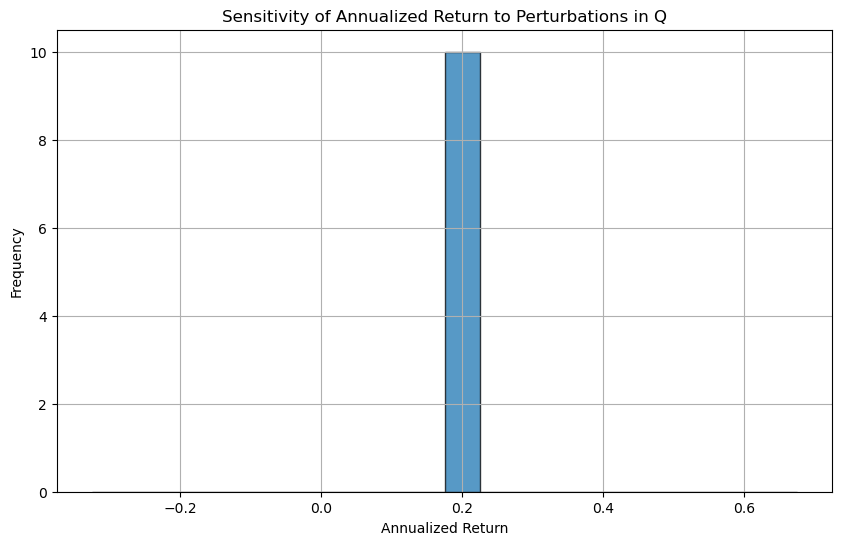

Q-Perturbation Sensitivity Summary:
Mean Annualized Return: 0.1749
Std. Dev. of Annualized Return: 0.0000
Min Annualized Return: 0.1749
Max Annualized Return: 0.1749


In [318]:
n_Q_sims = 10
tau0      = 0.025
annualized_returns_Q = []

for i in range(n_Q_sims):
    # Turn on perturbation
    PERTURB_Q = True

    # Run backtest as usual (will now use perturbed Q internally)
    result = Monte_Carlo_simulate(tau0)
    port_cum = result["portfolio_cum_returns"]

    # Compute annualized return
    n_days    = len(port_cum)
    final_ret = port_cum.iloc[-1]
    ann_ret   = (1 + final_ret) ** (252 / n_days) - 1
    annualized_returns_Q.append(ann_ret)

    # Turn off perturbation
    PERTURB_Q = False

annualized_returns_Q = np.array(annualized_returns_Q)

# Plot distribution
plt.figure(figsize = (10,6))
plt.hist(annualized_returns_Q, bins = 20, edgecolor = 'k', alpha = 0.75)
plt.title("Sensitivity of Annualized Return to Perturbations in Q")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Print summary statistics
print("Q-Perturbation Sensitivity Summary:")
print("Mean Annualized Return: {:.4f}".format(np.mean(annualized_returns_Q)))
print("Std. Dev. of Annualized Return: {:.4f}".format(np.std(annualized_returns_Q)))
print("Min Annualized Return: {:.4f}".format(np.min(annualized_returns_Q)))
print("Max Annualized Return: {:.4f}".format(np.max(annualized_returns_Q)))